< 주요 단계>
- 큰 그림 보기
- 데이터 구하기
- 통찰을 위한 탐색, 시각화
- 머신러닝 알고리즘 용 데이터 준비
- 모델 선택 , 훈련
- 하이퍼 파라미터 튜닝
- 솔루션 제시
- 모니터링, 유지보수

In [1]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/rickiepark/handson-ml2/master/'
HOUSING_PATH = os.path.join("/content/drive/MyDrive/handson_ml/datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + 'datasets/housing/housing.tgz'

def fetch_housing_data(housing_url =HOUSING_URL, housing_path = HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path) 
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path = housing_path)
    housing_tgz.close()

In [2]:
fetch_housing_data()

In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

In [4]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()
 # total_beadrooms 의 경우 20433 개만 존재, 207개 처리필요
 # ocean_proximity 만 type = object , head로 확인한 결과 범주형 변수 categorical 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
# 어떤 카테고리가 있고 각 카테고리마다 얼마나 많은 구역이 있는지 확인
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
housing.describe()
# std : 값이 퍼져있는 정도를 표현하는 표준편차

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


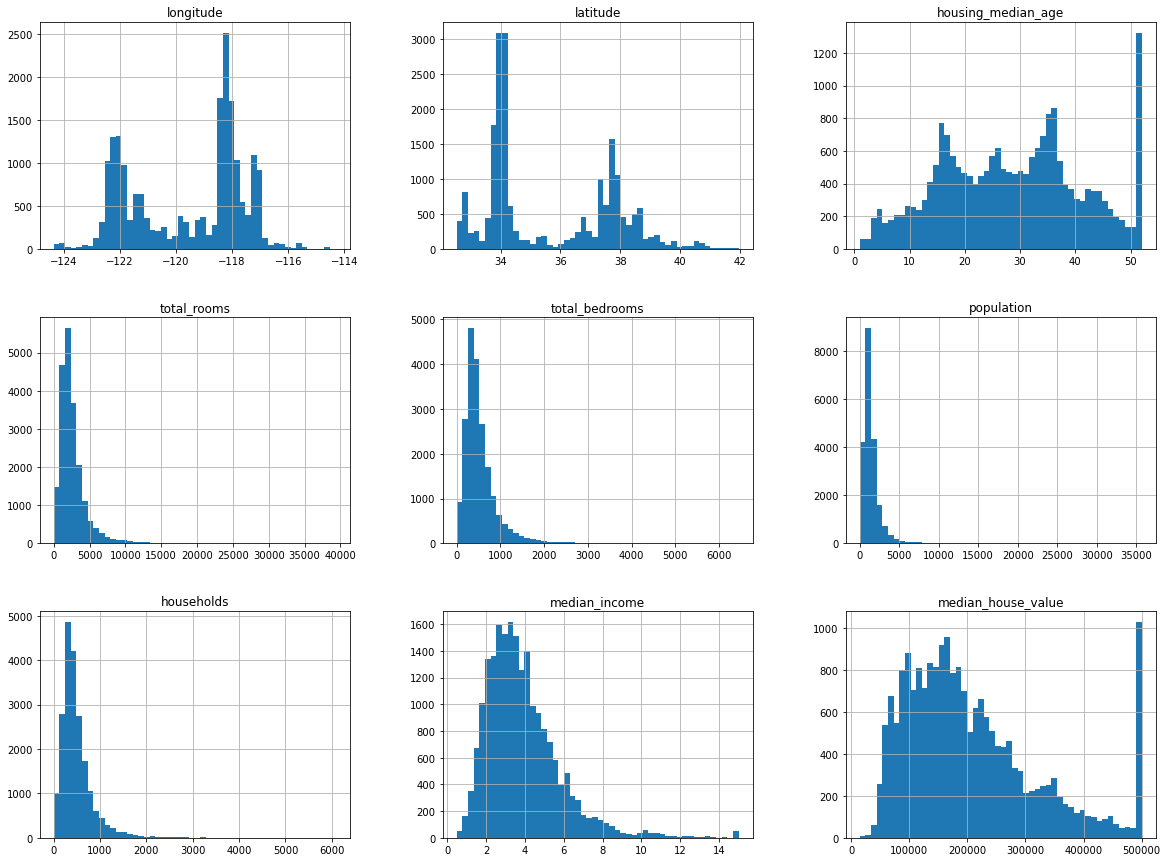

In [8]:
# 각 숫자형 특성을 히스토그램으로 그리기
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins = 50, figsize = (20, 15))
plt.show()

# 1. median income 이 달러가 아님
# 2. housing median age 와 median hous value 역시 최댓값/최솟값 한정
## 중간 주택 가격의 경우, 타겟 속성이로 사용되기 때문에 심각한 문제가 될 수 있음
## 가격이 한곗값을 넘지않도록 학습될 수 있음, 문제일지 아닐지에 대해 클라이언트팀과 검토 필요
## 만약 한계값 이상의 값을 예측해도 되며 정확도를 올려야 한다면? 
### 선택 1. 한곗값 밖 구역에 대한 레이블 구함
### 선택 2. 훈련세트, 테스트 세트에서 모두 제거 
#3. feature 들의 scale 차이가 다름
#4. 대부분의 히스토그램 꼬리가 두꺼움, 가운데보다 오른쪽으로 멀리 뻗어있음
## 이런 경우 머신러닝 모델이 패턴 찾기 어렵기에, 중간 종모양의 분포가 되도록 변형 예정

#-> 이 작업은 test set 분리 후 확인 필요

In [9]:
# 랜덤시드 고정
import numpy as np
np.random.seed(2021)

In [10]:
# data snooping 편향 : 우리 뇌가 데이터에 속아 데이터 중심적인 모델 선택, 이후 실제 데이터에 부적합 결과물 생성 가능성 존재
## 전체 데이터의 20%를 떼어놓고 시작

import numpy as np
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [11]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), 'train +', len(test_set), 'test')

16512 train + 4128 test


In [12]:
# 반복시 랜덤하게 데이터가 추출되어 결국 모델은 모든 데이터에 노출될 가능성이 높음
## 해결책 1. train, test set 별도 저장
## 해결책 2. 난수 인덱스 동일하게생성되도록 np.random.permutation() 호출 전 np.random.seed() 고정

# 위의 두가지는 다음번 업데이트된 데이터셋을 사용ㅇ할 시 문제
## 일반적인 해결책 : 샘플의 식별자를 사용하여 테스트셋으로 보낼지 말지 정함

from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) &  0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]  

In [13]:
# 주택데이터셋에는 식별자 칼럼이 없어, 행의 인덱스를 대신 사용

housing_with_id = housing.reset_index() # index 열 추가된 df
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')


In [14]:
# 새 데이터는 데이터셋 끝에추가 되어야 하고, 다른 행에 영향끼치면 안됨
# 인덱스가 아니라 다른, 식별자를 만들어야 한다면 아래와 같이도 응용 가능
housing_with_id['id'] = housing['longitude']  * 1000 + housing['latitude']
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'id')

In [15]:
# 사이킷런으로 진행, 무작위 샘플링, 데이터 셋이 작으면 샘플링 편향 발생할 수 있음 
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 2021)

In [16]:
# 계층적 샘플링이 필요, 실제 데이터와 유사한 분포로 학습 셋을 만들어 모델을 태워야 모델의 정확성 높음

# 중간 소득이 타겟 변수(=중간 주택 가격) 예측 하는데 매우 중요하다고 한다면, 
# 테스트 셋이 여러 소득 카테고리 대표할 수 있도록 구성되어야 함 
# 중간 소득은 연속형 변수이기 때문에 카테고리 특성을 별도로 만들어야 함
# 계층별로 데이터셋에 충분한 샘플수가 있어야, 편향되지 않은 추정이 가능
## = 너무 많은 계층으로 나누지 말 것, 한 계층 내 데이터가 충분할 것

# 중간 소득을 1.5로 나누고, ceil 함수로 카테고리 변수로 변경

housing['income_cat'] = np.ceil(housing['median_income']/ 1.5)
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace = True)

<AxesSubplot:>

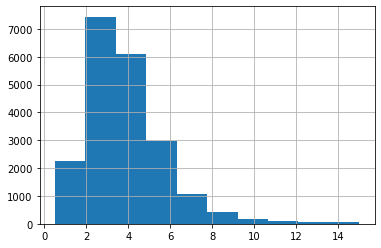

In [17]:
housing.median_income.hist()

In [18]:
# np.where  대신 이렇게도 작성할 수 있음
housing['income_cat2'] = pd.cut(housing['median_income'],
                                bins = [0., 1.5, 3.0, 4.5, 6., np.inf],
                                labels = [1,2,3,4,5])
housing.income_cat2.value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat2, dtype: int64

<AxesSubplot:>

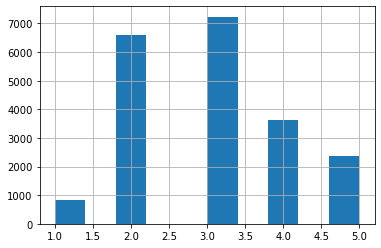

In [19]:
housing.income_cat.hist()

In [20]:
# 소득 카테고리 기반 계층 샘플링
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 2021)
for train_index, test_index, in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [21]:
# 아래 결과가 테스트셋의 소득 카테고리와 유사하다면? 계층적으로 잘 나눈 것
# 무작위 샘플링의 경우, 학습 - 테스트 셋 간의 구성 비율이 만힝 다를것

housing['income_cat'].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [22]:
# import_cat 삭제하여 원래 상태로 되돌리기
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis= 1, inplace = True)
    set_.drop('income_cat2', axis= 1, inplace = True)

In [23]:
# 2.4 데이터 이해를 위한 탐색과 시각화

housing = strat_train_set.copy()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

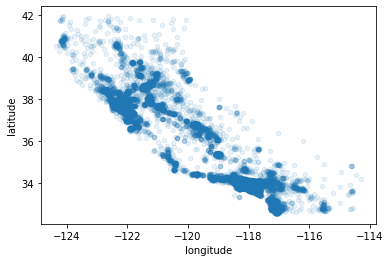

In [24]:
housing.plot(kind = 'scatter', x = 'longitude', y= 'latitude', alpha =0.1)
# 캘리포니아 지역은 잘 보여주지만 어떤 패턴을 찾기는 어렵다. 
# alpha = 0.1 로 설정하여 데이터 포인트가 밀집된 영역과 그렇지 않은 영역을 찾아보자
# 음영이 두드러진 곳과 그렇지 않은 곳을 확인할 수 있음

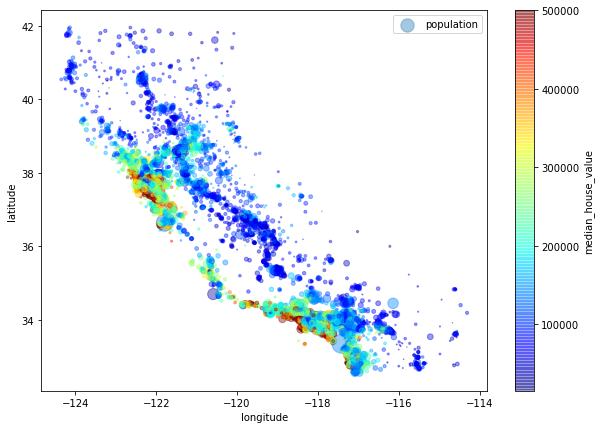

In [25]:
# 주택가격
housing.plot(kind = 'scatter', x= 'longitude', y='latitude', alpha = 0.4,
              s = housing['population']/100, label = 'population', figsize = (10,7),
              c = 'median_house_value', cmap = plt.get_cmap('jet'), colorbar = True,
              sharex=False)

plt.legend()
# 빨간색은 높은 가격, 파란색은 낮은 가격, 큰 원은 인구가 밀집된 지역을 나타냄
# 이 그림에서 주택가격은 지역과 인구밀도에 관련성이 있다는 것을 알 수 있는데,
# 군집 알고리즘을 사용해 주요 군집을 찾고 군집의 중심까지 거리를 재는 특성을 추가할 수 있다


In [26]:
# 상관관계 조사
## 데이터셋이 크지 않으므로 모든 특성간의 표준 상관계수 standard correlation coefficience 구해줌
corr_matrix = housing.corr()

## 상관관계는 선형적인 상관관계만 측정하며, 기울기와 상관없음

In [27]:
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.685647
total_rooms           0.131933
housing_median_age    0.109093
households            0.064239
total_bedrooms        0.048507
population           -0.024331
longitude            -0.055039
latitude             -0.135455
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

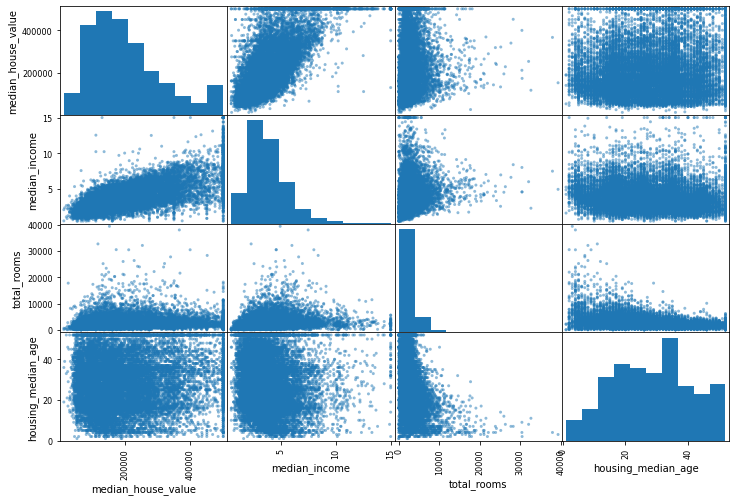

In [28]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value','median_income','total_rooms','housing_median_age']
scatter_matrix(housing[attributes], figsize=(12,8))

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

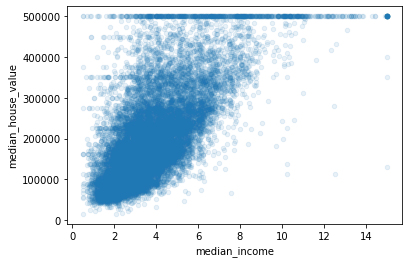

In [29]:
# 이 중에서 median_house_value 예측하는데에 도움을 가장 많이 받을 만한것은? 
# 가장 상관계수가 높은 median_income!

housing.plot(kind = 'scatter', x = 'median_income', y ='median_house_value', alpha = 0.1)

# 여기서 볼 수 있는 것? (1) 상관관계가 매우 강함 (2) 앞서 본 가격 제한값 500,000에서 수평선 확인됨
# 알고리즘이 데이터에서 이런 이상한 형태를 학습하지 않도록 해당 구역을 제거 (-> 제거만이 답일까?)

In [30]:
# 현재까지 (1) 조금 이상한 데이터 확인 (2) predictor - target  간의 상관관계 확인 
## 꼬리가 두꺼운 분포 (왜도 높을 경우) 데이터를 로그 스케일 등으로 변경 필요# 

In [31]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [32]:
corr_matrix = housing.corr()

In [33]:
corr_matrix['median_house_value'].sort_values(ascending = False)


#새롭게 만든 rooms_per_household 은 전체 방 갯수나 침실 개수보다 중간 주택가격과의 상관관계가 더 높다
# 침실/방의 비율이 낮은 집은 더 비싼 경향이 있다 

median_house_value          1.000000
median_income               0.685647
rooms_per_household         0.148905
total_rooms                 0.131933
housing_median_age          0.109093
households                  0.064239
total_bedrooms              0.048507
population_per_household   -0.022100
population                 -0.024331
longitude                  -0.055039
latitude                   -0.135455
bedrooms_per_room          -0.256906
Name: median_house_value, dtype: float64

In [35]:
# 2.5 데이터 자동화
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()


In [36]:
# 데이터 정제 - 수치형
## nan 값을 제거하거나, 전체 feature 를 삭제하거나, 다른 값으로 대체 (0, median 등)

housing.dropna(subset = ['total_bedrooms'])
housing.drop('total_bedrooms', axis = 1)
median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median, inplace = True)

In [37]:
# 사이킷런의 모듈러를 사용하여, 한번에 데이터 정제와 처리가 되도록 파이프라인을 구성
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = 'median')
housing_num = housing.drop('ocean_proximity', axis= 1)

imputer.fit(housing_num)

# imputer 는 각 특성의 중간값을 계산해서 그 결과를 객체의 statistics_속성에 저장
imputer.statistics_

array([-118.5    ,   34.26   ,   29.     , 2127.     ,  436.     ,
       1169.     ,  410.     ,    3.53715])

In [38]:
housing_num.median().values

array([-118.5    ,   34.26   ,   29.     , 2127.     ,  436.     ,
       1169.     ,  410.     ,    3.53715])

In [39]:
X = imputer.transform(housing_num)

In [40]:
housing_tr = pd.DataFrame(X, columns = housing_num.columns, 
                          index = housing_num.index)

In [41]:
# 데이터 정제 - 텍스트와 범주형 특성다루기
housing_cat = housing[['ocean_proximity']]
housing_cat.head() # 임의 텍스트가 아니라 범주형 정보 -> ordinalencoder 클래스 사용

,ocean_proximity
1582,<1H OCEAN
19561,INLAND
6538,<1H OCEAN
11018,<1H OCEAN
7189,<1H OCEAN


In [42]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [3.],
       [0.],
       [1.]])

In [43]:
ordinal_encoder.categories_ # 이 변수를 사용하면 카테고리 목록을 받아올 수 있음
# 다만 범주형 변환의 문제점은 0과 1, 3이라는 수치가 각각 추가적인 (의도치 않은) 의미를 갖게 된다는 것
# 실질적으로 해당 데이터는 1과 3만큼의 배수 / 거리 차이를 보이지 않는 값이지만, 
# 알고리즘 모델은 두 값이 차이를 인식하여 모델에 학습하고 결과로 반환

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [44]:
# 그래서 대신 one-hot encoder 사용하기도 함
from sklearn.preprocessing import OneHotEncoder 
cat_encoder = OneHotEncoder()

housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot  # one hot encoder 사용하면 sparse matrix 로 변환해줌

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [45]:
housing_cat_1hot.toarray() # 로 변환하면 array 형태의 넘파이 배열로 변환도 가능

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [46]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [47]:
# TransformerMinin 상속하면 fit_transform() 이 자동적으로 생성
# BaseEstimator 를 상속하면 (그리고 생성자에 *args나 **kargs 를 사용하지 않으면) 
# 하이퍼 파라미터 튜닝에 필요한 두 메서드를 추가로 얻게됌

from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin): 
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room # 이 인자를 하이퍼 파라미터 튜닝 시 on / off 로 사용하고자
    def fit (self, X, y = None):
        return self 
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:,households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        
        else: 
            return np.c_[X, rooms_per_household, population_per_household]


In [48]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

# add_bedrooms_per_room 이라는 파라미터를 가지며, 기본값을 True 로 지정
# 이 하이퍼파라미터로 데이터 준비를 하고, 자동화 하면 더 많은 조합을 자동으로 시도해볼 수 있고 최상의 조합을 찾을 가능성 높혀줌

In [49]:
#특성 스케일링 feature scaling
## 정규화 min-max scaling : 0~ 1사이의 값으로 만듦 -> feature_range 매개변수로 범위 변경도 가능 -> 이상치 영향 받음 
## 표준화  standardization : 평균을 빼고 표준편차로 나누어 분포의 분산이 1이 되게 함 -> 이상치의영향을 덜받음


In [50]:
# pipeline 사용하여 정확한 순서대로 실행되도록 함
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
                         ('imputer', SimpleImputer(strategy='median')), # 각 메서드는 fit_transform() 이라는 매서드를 순서대로 호출
                         ('attribs_adder', CombinedAttributesAdder()), 
                         ('std_scaler', StandardScaler()),# 마지막 추정기인 표준화 매서드는 transform 을 가지고 있음
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

# 마지막 추정기와 동일한 메서드를 제공
# 범주형과 수치형 열은 이렇게 다룰 수 있음

In [51]:
housing_num_tr

array([[-1.20934491,  1.04267173, -0.84425062, ...,  1.39491337,
        -0.00632946,  1.2577463 ],
       [-0.70071417,  0.91613635, -2.11350192, ...,  0.3780268 ,
         0.03722784,  0.69320145],
       [ 0.76533913, -0.74288304,  0.42500067, ..., -0.31815426,
         0.12491002, -0.72756978],
       ...,
       [-0.41149277,  1.10828267, -0.92357883, ...,  0.1909568 ,
        -0.04563635, -0.39825195],
       [-1.62821728,  1.29574248, -1.08223524, ..., -0.11481016,
        -0.0596234 ,  0.1827588 ],
       [ 0.74539283, -0.87410491, -0.20962498, ..., -0.58042375,
        -0.15549202,  0.02750897]])

In [52]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([ # 이건 칼럼명을 선택할 수 있음 
                                   ('num', num_pipeline, num_attribs), # 밀집 행렬을 반환 : 희소행렬과 밀집행렬이 섞여있을때, 최종 행렬의 밀집정도 추정
                                   ('cat', OneHotEncoder(), cat_attribs),# 이름, 변환기, 변환기 적용될 열 이름
])

housing_prepared = full_pipeline.fit_transform(housing) # 최종적으로 주택 데이터에 적용



In [53]:
# 모델 선택과 훈련

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [54]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print('예측 : ', lin_reg.predict(some_data_prepared))
print('레이블:', list(some_labels)) 

#예측은 많이 벗어났으나 작동은 함


예측 :  [461640.5999748  148607.96499665 171944.40987805 395338.33994739
 193932.65076416]
레이블: [500001.0, 145900.0, 137500.0, 349500.0, 126000.0]


In [55]:
# mean_squared_error 함수로 회귀모델의 rmse 를 측정
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

# 대부분 구역의 중간 주택가격은 120,000 ~ 265,000임
# 예측 오차가 68000원대 -> 훈련 데이터에 과소적합된 사례
## feature 들이 좋은 예측을 만들만큼 충분한 정보를 제공하지 못했거나, 모델이 충분히 강력하지 못하다는 사실
## 과소적합을 해결하는 주요 방법 : 
## (1) 더 강력한 모델을 선택
## (2) 훈련 알고리즘에 더 좋은 feature 추가
## (3) 모델 규제 감소

68404.93350828667

In [56]:
# 만약 더 복잡한 모델 적용하면 어떨까?
# decision tree regressor 훈련
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [57]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse
# rmse 가 0이 나왔다는 것, 모델이 데이터에 심하게 과대 적합되었다는 뜻
# 교차검증을 사용해서 평가를 다시한번 진행해야 함

0.0

In [58]:
# train_test_split 함수 사용해서 훈련세트를 더 작은 훈련세트와 검증세트로 나누고 나서 훈련-검증 진행
# k-fold cross validation 기능 사용할 수 있음

from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, 
                         scoring = 'neg_mean_squared_error', cv = 10) #scoring 함수는 클수록 좋은 함수를 사용해야 하기에 neg 를 사용
 # 10개 폴드를 만들어, 매번 다른 폴드를 선택해 평가에 사용하고 나머지 9개는 훈련에 사용
tree_rmse_scores = np.sqrt(-scores)
tree_rmse_scores # 10개의 평가 점수가 담긴 배열이 결과에 나옴


array([67919.95131384, 68332.03998958, 69701.70933247, 75287.69780399,
       69649.28207936, 70583.68898164, 67630.49365122, 69739.35908518,
       70875.6608348 , 68070.71213048])

In [59]:
def display_scores(scores):
    print('점수: ', scores)
    print('평균: ', scores.mean())
    print('표준편차: ', scores.std())
display_scores(tree_rmse_scores)

# 원하는 수준의 점수도 아님
# 선형회귀 모델보다 안좋은 결과
# 교차검증으로 모델의 성능을 추정하는 것뿐 아니라, 이 추정이 얼마나 정확한지(=표준편차) 측정 가능
# 결정트리 점수가 평균 70474에서 +- 2500원 정도


점수:  [67919.95131384 68332.03998958 69701.70933247 75287.69780399
 69649.28207936 70583.68898164 67630.49365122 69739.35908518
 70875.6608348  68070.71213048]
평균:  69779.0595202571
표준편차:  2128.4829117827835


In [60]:
# 이 결과를 선형회귀 모델 점수에 비교를 한다면
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, 
                             scoring= 'neg_mean_squared_error', cv = 10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

점수:  [68025.19035271 66407.0500118  68377.39624814 71446.07592935
 70014.18967416 68300.1414953  67004.07734088 73059.45021752
 64328.98912013 69627.04270158]
평균:  68658.96030915753
표준편차:  2389.0214902206876


In [61]:
# randomforest regressor 모델 : 랜포는 feature 를 무작위로 선택해서 많은 결정트리를 만들고 그 예측을 평균냄
# -> 앙상블 학습

In [62]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

forest_prediction = forest_reg.predict(housing_prepared)
forest_rmse_score = np.sqrt(mean_squared_error(forest_prediction, housing_labels))
display_scores(forest_rmse_score)

# 훈련세트에 대한 점수가 검증셋보다 훨씬 낮음 : 과대적합
# 과대적합 해결 방법 
## (1) 모델 간단히 변경
## (2) 제한을 함 (규제)
## (3) 더 많은 훈련 데이터 수집

#  mean_squared_erro(squared = False) 하면 np.sqrt() 사용하지 않고서도 rmse  얻을 수 있음


점수:  18504.533437041384
평균:  18504.533437041384
표준편차:  0.0


In [63]:
# 여러 종류의 알고리즘으로 하이퍼 파라미터 조정에 너무 많은 시간을 들이지 않으면서 다양한 모델(따양한 커널의 서포트 백터 머신, 신경망)시도
# 가능성 있는 2~5개 모델을 선택하는 것이 목표

# 실험한 모델을 모두 저장하면 필요할 때 쉽게 복원 가능
# 저장 목록 : 교차 검증 점수, 실제예측값, 하이퍼파라미터 훈련된 모델 파라미터 
# pickle, joblib 사용

In [64]:
import joblib 
joblib.dump(forest_reg, 'my_model.pkl')

my_model_loaded = joblib.load('my_model.pkl')

In [65]:
# 모델 세부 튜닝

## 그리드 탐색 : 가장 단순한 방법 : 적절 하이퍼파라미터 조합을 찾을 때 까지 수동으로 하이퍼파라미터 조정
## GridSearchCV 사용
## 가능한 모든 하이퍼 파라미터 조합에 대해 교차 검증을 사용해 평가

from sklearn.model_selection import GridSearchCV 

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2,4,6,8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2,3,4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv = 5,
                           scoring = 'neg_mean_squared_error', 
                           return_train_score = True)
grid_search.fit(housing_prepared, housing_labels)
# 어떤 하이퍼파라미터 값을 지정해야 할지모르면 10거듭제곱수로 시도

# param_grid 설정에 따라 첫번째dict 내 값을 모두 진행 : 3 x 4 = 12경우의 수
# 그리고 두번째 dic 값을 모두 진행 : 2 x3 = 6경우의 수 
# RandomForestRegressor 하이퍼파라미터 값에 대한 테스트 12 + 6 = 18회의 조합 탐색
# 그리고 각각 다섯번 모델 훈련 (5 fold cv라서)

grid_search.best_params_ # 최대값인 8, 최대값인 30번이 나왔음 : 더 최적화 될 여지 있을 수 있음

{'max_features': 6, 'n_estimators': 30}

In [66]:
# 최적의 추정기에 직접 접근도 가능
grid_search.best_estimator_

# GridSearchCV가 기본값인 refit=True로 초기화 한다면, 교차검증으로 최적의 추정기를 

RandomForestRegressor(max_features=6, n_estimators=30)

In [67]:
cvres = grid_search.cv_results_

In [68]:
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)
# 이렇게 해서 보니까 rmse 점수가 가장 낮은 경우가 
# 49387.98622622433 {'max_features': 8, 'n_estimators': 30}

64402.19186131319 {'max_features': 2, 'n_estimators': 3}
55790.82096370593 {'max_features': 2, 'n_estimators': 10}
52715.601646911 {'max_features': 2, 'n_estimators': 30}
59945.68078801026 {'max_features': 4, 'n_estimators': 3}
52681.312963710916 {'max_features': 4, 'n_estimators': 10}
49861.18375297503 {'max_features': 4, 'n_estimators': 30}
59331.197818340246 {'max_features': 6, 'n_estimators': 3}
51112.46400570821 {'max_features': 6, 'n_estimators': 10}
49533.523888267155 {'max_features': 6, 'n_estimators': 30}
57803.54849436607 {'max_features': 8, 'n_estimators': 3}
51533.9979612622 {'max_features': 8, 'n_estimators': 10}
49643.645619934054 {'max_features': 8, 'n_estimators': 30}
62313.44488763898 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54742.54840122303 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60325.39131175544 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52370.28374084589 {'bootstrap': False, 'max_features': 3, 'n_estimators': 1

In [69]:
# 랜덤탐색 : 하이퍼파라미터 경우의수가 커지면 RandomizedSearchCV 사용하는 것이 좋음
## 각 반복마다 하이퍼파라미터에 임의의 수를 대입하여 지정한 횟수만큼 평가
## 장점 : 1,000회 반복하도록 실행하면 각기 다른 1000개의 값을 탐색
## 장점2 : 단순히 반복횟수를 조절하는 것만으로도 하이퍼파라미터 탐색에 필요한 리소스 제어가 가능

# 설정값이 연속형인 경우, 랜덤 탐색이 나음

In [70]:
from sklearn.model_selection import RandomizedSearchCV 
from scipy.stats import randint

param_distribs = {
    'n_estimators': randint(low=1, high = 200),
    'max_features': randint(low = 1, high =8),
}

forest_reg = RandomForestRegressor(random_state = 930)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions = param_distribs, 
                                n_iter = 10, cv = 5, scoring = 'neg_mean_squared_error', random_state= 930)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=930),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000029AB9DAC7F0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000029AB9D85B80>},
                   random_state=930, scoring='neg_mean_squared_error')

In [71]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

51266.94874507271 {'max_features': 6, 'n_estimators': 11}
48983.72908419734 {'max_features': 7, 'n_estimators': 43}
48357.17096948853 {'max_features': 6, 'n_estimators': 96}
48615.76846279271 {'max_features': 6, 'n_estimators': 66}
48935.802097633 {'max_features': 5, 'n_estimators': 119}
49803.23544160064 {'max_features': 3, 'n_estimators': 193}
54520.343280741254 {'max_features': 1, 'n_estimators': 172}
52132.28993104457 {'max_features': 2, 'n_estimators': 37}
51321.75269800905 {'max_features': 2, 'n_estimators': 199}
51143.54692958654 {'max_features': 5, 'n_estimators': 15}


In [72]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([8.65808465e-02, 8.33504542e-02, 4.12925898e-02, 1.96202938e-02,
       1.50967168e-02, 1.79511722e-02, 1.49879463e-02, 3.55743900e-01,
       7.07270250e-02, 1.03086765e-01, 1.48516150e-02, 9.59384703e-03,
       1.58368931e-01, 1.92787280e-04, 3.00155108e-03, 5.55355874e-03])

In [73]:
# 앙상블
# 모델 세밀하게 튜닝하는 또 다른 방법 : 최상의 모델 연결
# 결정트리 decision tree 하나보다 앙상블인 randomforest 가 더 좋은 성능을 보임

In [74]:
# 최상의 모델과 오차 분석
# 최상의 모델 분석 시, 모델에 대한 좋은 통찰을 얻을 수 있음
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances



array([8.65808465e-02, 8.33504542e-02, 4.12925898e-02, 1.96202938e-02,
       1.50967168e-02, 1.79511722e-02, 1.49879463e-02, 3.55743900e-01,
       7.07270250e-02, 1.03086765e-01, 1.48516150e-02, 9.59384703e-03,
       1.58368931e-01, 1.92787280e-04, 3.00155108e-03, 5.55355874e-03])

In [75]:
# 중요도와 특성이름 같이 반환
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

In [76]:
sorted(zip(feature_importances, attributes), reverse = True)
# 이 내용을 바탕으로 덜 중요한 특성은 제외할 수 있음 
# 시스템이 특정 오차를 만들었다면, 왜 그런 문제가 생겼는지 이해하고
# 문제를 해결하는 방법이 무엇인지 찾아야 함
# 추가 특성을 포함, 불필요한 특성 제거, 이상치 제외 등

[(0.35574389987829963, 'median_income'),
 (0.15836893145431805, 'INLAND'),
 (0.10308676494381076, 'pop_per_hhold'),
 (0.0865808464659341, 'longitude'),
 (0.08335045421403152, 'latitude'),
 (0.07072702498922037, 'rooms_per_hhold'),
 (0.041292589805341444, 'housing_median_age'),
 (0.019620293754316658, 'total_rooms'),
 (0.017951172172137167, 'population'),
 (0.015096716819684181, 'total_bedrooms'),
 (0.01498794634183987, 'households'),
 (0.014851615027518942, 'bedrooms_per_room'),
 (0.009593847032213764, '<1H OCEAN'),
 (0.005553558739061043, 'NEAR OCEAN'),
 (0.003001551081857629, 'NEAR BAY'),
 (0.00019278728041483893, 'ISLAND')]

In [77]:
# 테스트세트로 시스템 평가하기
## 어느정도로 모델을 튜닝하면 ㅋㅋㅋ만족할 만한 모델을 얻게 된다
# 이제 테스트 셋에서 최종 모델을 평가할 차례
# 테스트셋에서 예측변수와 레이블을 얻은 후, full_pipeline 을 사용해 데이터 변환 
## 테스트셋에서 훈련하면 안되므로 fit() 이 아니라 transform() 만 사용해야 함

final_model = grid_search.best_estimator_
X_test = strat_test_set.drop('median_house_value', axis = 1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)

final_rmse = np.sqrt(final_mse)


In [78]:
# 일반화 오차의 추정이 추운하지 않음
# 이 추정값이 얼마나 정확할까? 
## scipy.stats.t.interval() 을 사용하여 일반화 오차의 95% 신뢰구간을 계산할 수 있음

from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc = squared_errors.mean(),
                         scale = stats.sem(squared_errors)))

# 하이퍼파라미터 튜닝을 많이 했다면 교차 검증을 사용한것 보다 성능이 조금 낮을 것이다
# 그러나 조금 더 성능을 좋게 하기 위해 하이퍼파라미터 튜닝을 또 시도할 필요는 없다
# 오히려 그렇게 향상된 성능은 새로운 데이터에 일반화 되기 어려움

array([47750.99423206, 51897.50934303])

In [79]:
# 프로젝트 론칭 직전 단계에 왔다
## 학습한 것, 한 일과 하지 않은 일, 수립한 가정, 시스템 제한 사항 등을 강조하면서
# 솔루션과 문서를 출시하고, 
# 깔끔한 도표와 기억하기 쉬운 제목의 발표도 준비해야 함

In [80]:
# 이제 제품 시스템에 적용해야 함 : 코드 정리, 문서와 테스트 케이스 작성하는 것
# 모델을 상용 환경에 배포
# 한가지 방법 :
## 전체 전처리 파이프라인과 예측 파이프라인이 포함된 사이킷런 모델을 저장 : joblib
## 훈련 모델을 상용 환경에서 로드하고 predict() 메서드 호출해 예측 만듦
# 모델을 사용할때마다 로드 x -> 서버가 시작될 떄 모델을 로드
# + 웹 애플리케이션이 REST API를 통해 질의할 수 있는 전용 웹서비스로 모델을 사용할 수 있음

# 또 다른 방법 구글 클라우드 AI플랫폼과 같은 클라우드에 배포하는 것
## GCS google cloud storage 에 업로드
## AI플랫폼으로 이동하여 새로운 모델을 만들고 파일 지정

#배포가 마지막이 아님
## 일정 간격으로 시스템의 실시간 성능을 체크
## 성능이 떨어졌을 떄 알람을 통지할 수 있는 모니터링 코드를 작성해야 함
## 고장난 컴포넌트때문에 일어날 것 같은 갑작스러운 성능 감소
## 긴 시간 눈에 안띄는 성능 감소하는 상황도 감지해야 함
### 시간이 지나면서 모델 낙후되는 경향도 있음

##-> 모델의 실전 성능을 모니터링 해야함
### 해결책 1. 모델 전체 사진 중 한 샘플을 평가하는 사람에게 보내고, 사람이 직접 평가

## 모델이 실패했을 떄 무엇을 할지 정의, 어떻게 대비할지 관련 프로세스를 모두 준비해야 함
## 많은 작업임




In [ ]:
# 데이터가 계속 변화한다면, 데이터셋도 주기적으로 업데이트하고 모델 정기 훈련 필요
# 가능한 한 많은 것을 자동화 해야 함
## - 정기적으로 새로운 데이터 수집, 레이브 ㄹ추가
## - 모델 훈련하고 하이퍼파라미터 자동으로 세부 튜닝하는 스크립트 작성 (매일 또는 매주)
## - 업데이트 된 테스트셋에서 새로운 모델 vs 이전모델 평가하는 스크립트 작성, 성능감소여부 확인 

# 모델의 입력 데이터 품질 평가 

# 만든 모든 모델 백업 : 새로운 모델이 이슈가 있을 경우, 이전 모델로 빠르게 롤백하기 위한 절차 & 또구 준비 
## 데이터 일부분에 대해 모델 얼마나 잘 작동하는지 평가하기 위해 테스트셋을 여러 subset으로 나누는 경우 있음
# 이럴경우, 모델 강-약점 이해하는데 도움이 될 것